In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from PIL import Image
import timeit

## Q1

### 1

In [2]:
def dft(I):
    I = np.array(I)
    m, n = I.shape
    W_m = np.zeros((m, m), dtype=np.complex128)  
    W_n = np.zeros((n, n), dtype=np.complex128) 

    for i in range(m):
        for j in range(m):
            W_m[i, j] = np.exp(-2j*np.pi*i*j/m)

    for i in range(n):
        for j in range(n):
            W_n[i, j] = np.exp(-2j*np.pi*i*j/n)

    F_I = W_m @ I @ W_n
    return F_I

def idft(F_I):
    m, n = F_I.shape
    max_val = max(n, m)
    W_m = np.zeros((m, m), dtype=np.complex128)  
    W_n = np.zeros((n, n), dtype=np.complex128)  

    for i in range(m):
        for j in range(m):
            W_m[i, j] = np.exp(2j*np.pi*i*j/m)

    for i in range(n):
        for j in range(n):
            W_n[i, j] = np.exp(2j*np.pi*i*j/n)

    I = W_m @ F_I @ W_n
    I = I / (m * n)
    return I

In [15]:
color_image = Image.open("misc/5.2.10.tiff")
img = color_image.convert("L")

avg_5x5 = np.ones((5, 5))/25

In [3]:
def circular_convolution(I, H):
    N, M = I.shape
    J = np.zeros_like(I) 
    m, n = H.shape
    for i in range(N):
        for j in range(M):
            for u in range(m):
                for v in range(n):
                    x = (i - u) % N
                    y = (j - v) % M
                    J[i,j] += I[x, y] * H[u, v]
    return J

def circular_conloution_freq(I, H):
    pad_rows = I.shape[0] - H.shape[0]
    pad_cols = I.shape[1] - H.shape[1]
    padded_H = np.pad(H, ((0, pad_rows), (0, pad_cols)), mode='constant')
    J = idft(dft(I) * dft(padded_H))
    return J.real

Differences between images: -1.132774304045403e-10


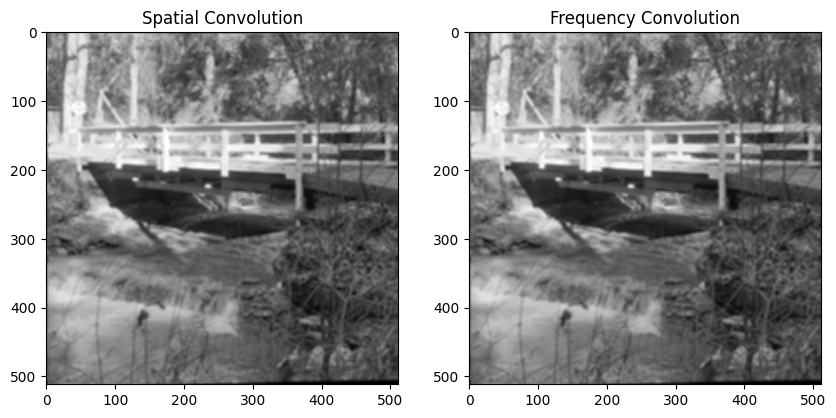

In [4]:
result_spatial = circular_convolution(np.array(img)/255,avg_5x5)
result_freq = circular_conloution_freq(np.array(img)/255,avg_5x5) 

difference = np.sum(result_spatial - result_freq)
print('Differences between images:', difference)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(result_spatial, cmap='gray')
axes[0].set_title('Spatial Convolution')

axes[1].imshow(result_freq, cmap='gray')
axes[1].set_title('Frequency Convolution')
plt.show()

we can see from the above difference  both are same spatial convoltion and frequency convolution

### 2

In [4]:
def linear_convolution(I, H):
    N, M = I.shape
    n, m = H.shape
    J = np.zeros((N + n - 1, M + m - 1))
    for i in range(N + n - 1):
        for j in range(M + m - 1):
            for u in range(n):
                for v in range(m):
                    if i - u >= 0 and i - u < N and j - v >= 0 and j - v < M:
                        J[i, j] += I[i - u, j - v] * H[u, v]
    return J

def linear_convolution_freq(I, H):
    # Double the size of the image
    n, m = I.shape[0], I.shape[1]
    n1, m1 = H.shape[0],H.shape[1]
    padded_I = np.pad(I, ((0, n), (0, m)), mode='constant')
    padded_H = np.pad(H, ((0, H.shape[0]), (0, H.shape[1])), mode='constant')
    J = circular_conloution_freq(padded_I, padded_H)
    return J[:(n+n1-1), :(m + m1 - 1)]

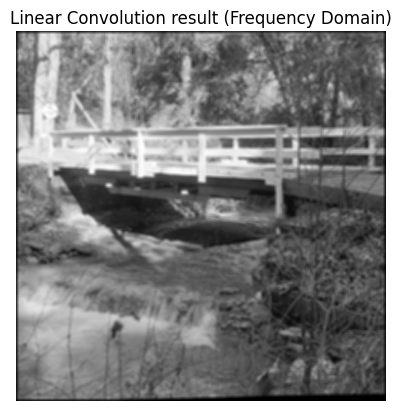

In [6]:
linear_conv_freq = linear_convolution_freq(np.array(img)/255,avg_5x5)
plt.imshow(linear_conv_freq, cmap='gray')
plt.axis('off')
plt.title('Linear Convolution result (Frequency Domain)')
plt.show()

image is obtained from padding the double the size of image then taking circular convolution

### 3

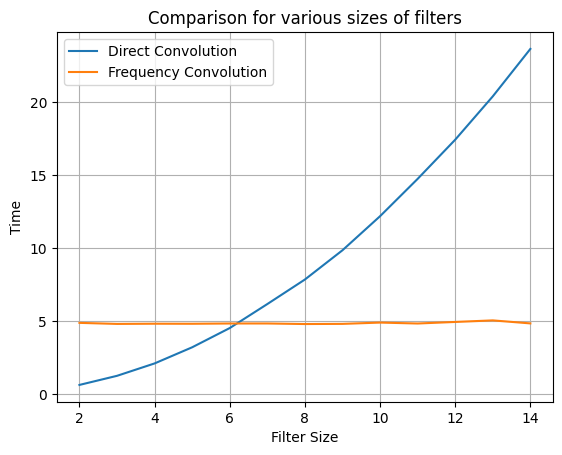

In [7]:
def timed(I, H, func):
    start_time = timeit.default_timer()
    func(I, H)
    return timeit.default_timer() - start_time


filter_sizes = range(2, 15)
time_convolution = []
time_freq_convolution = []
for i in filter_sizes:
    H = np.ones((i,i))/(i*i)
    I = np.array(img)/255
    time_convolution.append(timed(I, H, linear_convolution))
    time_freq_convolution.append(timed(I, H, linear_convolution_freq))


plt.plot(filter_sizes, time_convolution, label='Direct Convolution')
plt.plot(filter_sizes, time_freq_convolution, label='Frequency Convolution')
plt.xlabel('Filter Size')
plt.ylabel('Time')
plt.title('Comparison for various sizes of filters')
plt.legend()
plt.grid(True)
plt.show()

from the above graphs we can see as filter size increased frequncy convolution is faster bit for smaller size spatial convolution is faster this is beacause for small window sizes we can assume  for each window it takes constant time but as window size increases this can be taken as O(1) instead needed O(m) for each window slide but in freq domain no matter the size we pad to size double of image then take dot product do convolution so it takes almost same time irrespective of kernal size 

## Q2

### 1

In [21]:
def crop_image(image, crop_size):
    cropped_image = image[:crop_size, :crop_size]
    return cropped_image

def avg_filter(size):
    return np.ones((size, size)) / (size**2)

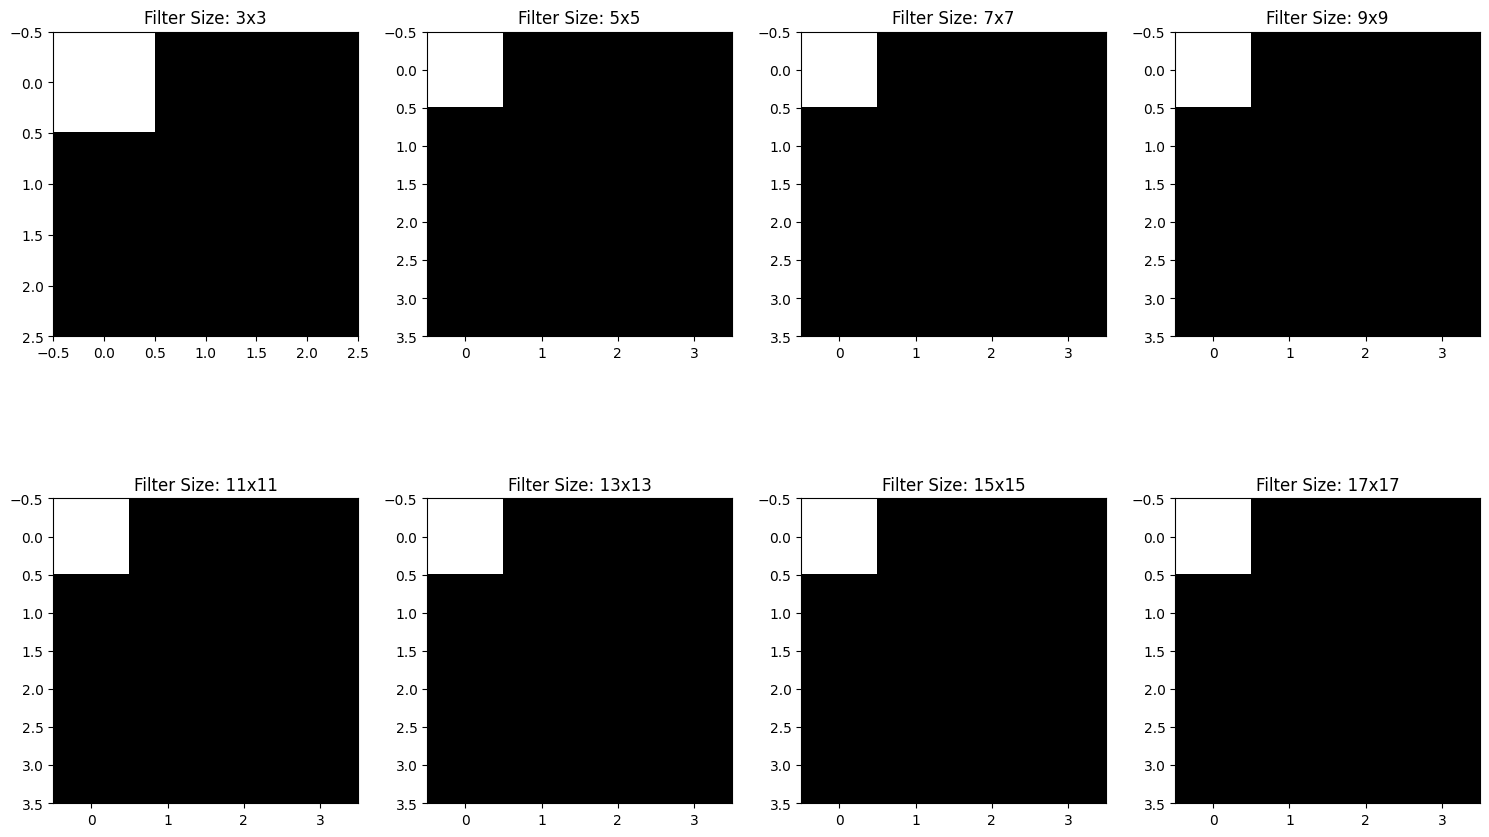

In [8]:
filter_sizes = [3,5,7,9,11,13,15,17]
num_filters = len(filter_sizes)
num_columns = 4
num_rows = (num_filters - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))

for i, size in enumerate(filter_sizes):
    row_index = i // num_columns
    col_index = i % num_columns
    H = avg_filter(size)
    H = dft(H)
    H = np.abs(H)
    H = crop_image(H, crop_size=4) # to visualize better
    axes[row_index, col_index].imshow(H, cmap='gray')
    axes[row_index, col_index].set_title(f'Filter Size: {size}x{size}')
     
plt.tight_layout()
plt.show()

filter paramater is size in average filtering,the top left corner is where dc(0,0) component lies we can see as freq increases signals are attenuated hence this is low pass filter also as filter size increases the high freq are strongly attenuated this can be seen as size of square is slightly decreasing 

### 2

In [20]:
def gaussian_filter(size, sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    gaussian_filter = np.exp(-(x*x + y*y)/(2.0 * sigma ** 2))
    return gaussian_filter / np.sum(gaussian_filter)

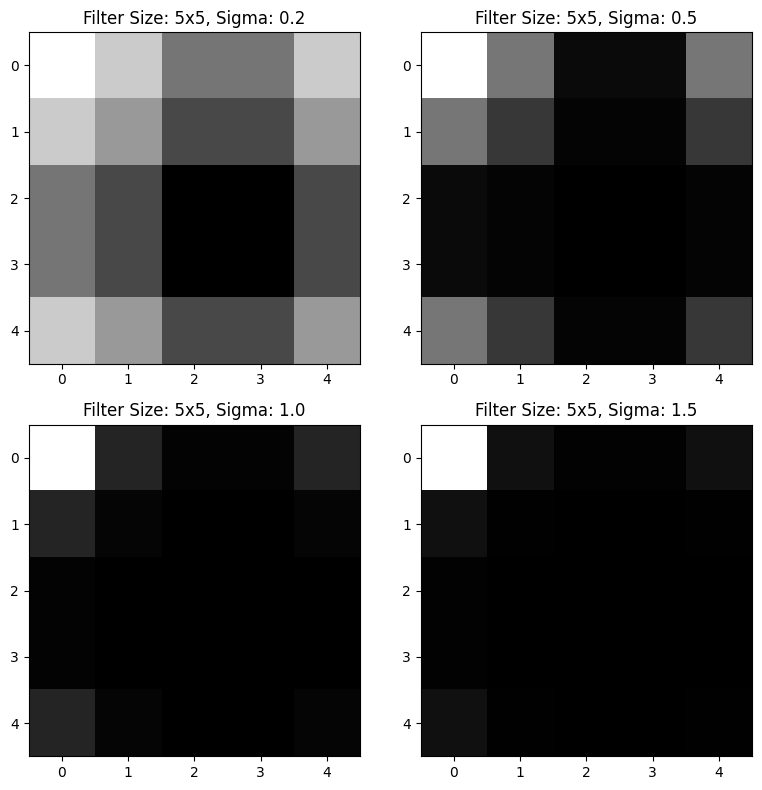

In [9]:
sigma_values = [0.2,0.5, 1.0, 1.5]
num_columns = 2
num_rows = (len(sigma_values) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(8, 4*num_rows))
for i, sigma in enumerate(sigma_values):
    row_index = i // num_columns
    col_index = i % num_columns
    size = 5  
    H = gaussian_filter(size, sigma)
    H = np.abs(dft(H))
    axes[row_index, col_index].imshow(H, cmap='gray')
    axes[row_index, col_index].set_title(f'Filter Size: {size}x{size}, Sigma: {sigma}')

plt.tight_layout()
plt.show()

filter parameter for gaussian filter is sigma,we can see gaussian filter is inface a low pass filter as we see white at dc(0,0) as freq increases its decrasing,as sigma increases the high freq signals are attenuated this can be seen as bottom right are dark(0)

### 3

In [19]:
def band_pass(size, sigma_low, sigma_high):
    return gaussian_filter(size, sigma_high) - gaussian_filter(size, sigma_low)

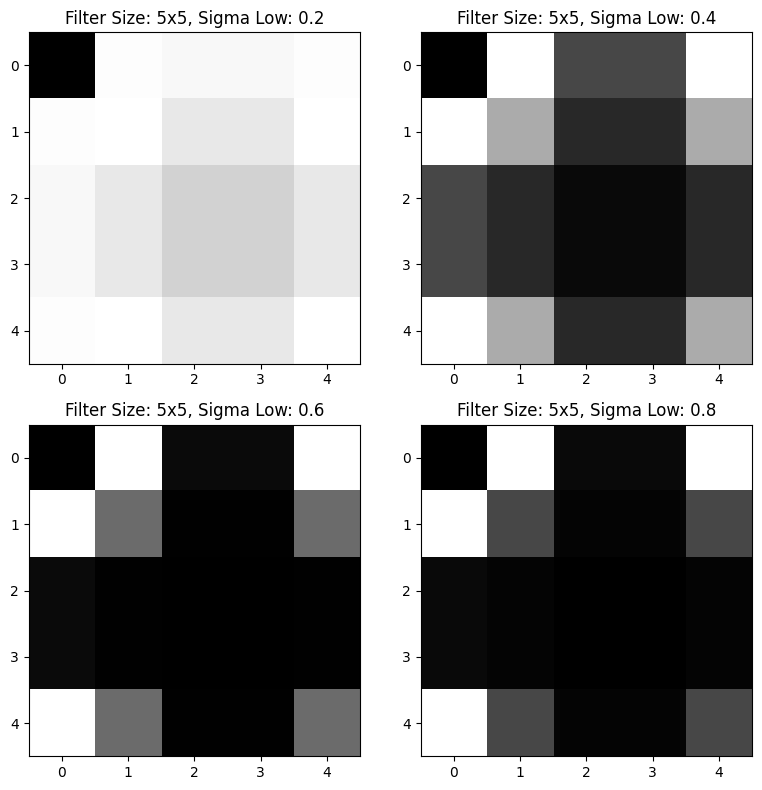

In [10]:
sigma_low_values = [0.2, 0.4, 0.6, 0.8]
num_columns = 2
num_rows = (len(sigma_low_values) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(8, 4*num_rows))
for i, sigma_low in enumerate(sigma_low_values):
    row_index = i // num_columns
    col_index = i % num_columns
    size = 5
    H = band_pass(size, sigma_low, 1.5)  # Using a fixed sigma_high value
    H = np.abs(dft(H))
    axes[row_index, col_index].imshow(H, cmap='gray')
    axes[row_index, col_index].set_title(f'Filter Size: {size}x{size}, Sigma Low: {sigma_low}')

plt.tight_layout()
plt.show()

The parameters of a bandpass filter include the sigma values of the low-pass and high-pass filters. In this scenario, the sigma value of the high-pass filter is fixed, while the sigma value of the low-pass filter is varied. As the sigma value of the low-pass filter decreases, the attenuation of lower frequency bands becomes less pronounced.

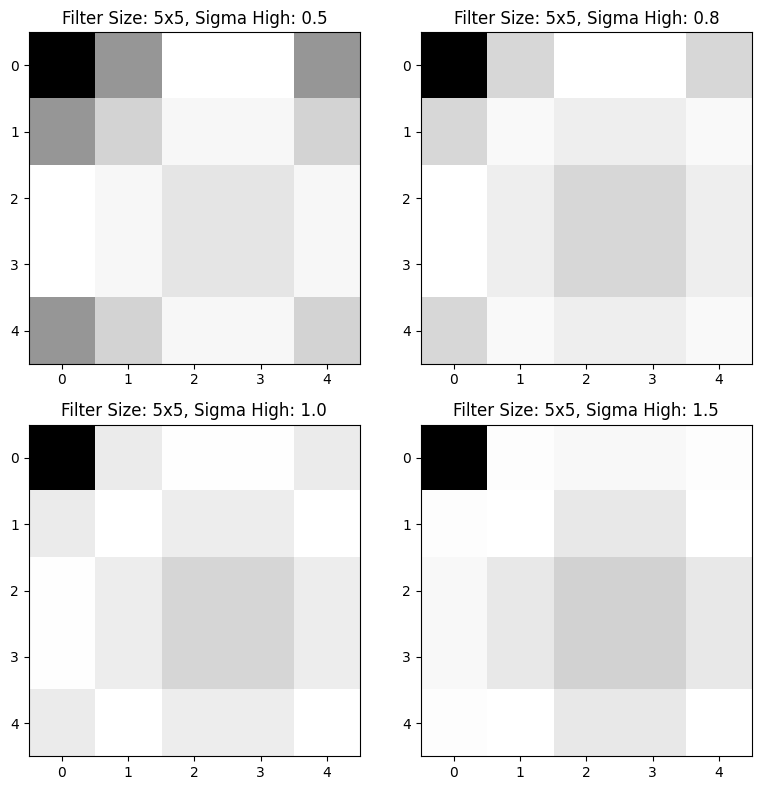

In [14]:
sigma_high_values = [0.5,0.8,1.0,1.5]
num_columns = 2
num_rows = (len(sigma_high_values) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(8, 4*num_rows))
for i, sigma_high in enumerate(sigma_high_values):
    row_index = i // num_columns
    col_index = i % num_columns
    size = 5
    H = band_pass(size, 0.2, sigma_high)  # Using a fixed sigma_low value
    H = dft(H)
    H = np.abs(H)
    axes[row_index, col_index].imshow(H, cmap='gray')
    axes[row_index, col_index].set_title(f'Filter Size: {size}x{size}, Sigma High: {sigma_high}')

plt.tight_layout()
plt.show()


In this scenario, the sigma value of the low-pass filter is fixed, while the sigma value of the high-pass filter is varied. As the sigma value of the high-pass filter increases at higher freq the signal is less attenuated.

### 4

In [18]:
def laplacian(size):
    laplacian_kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    laplacian_filter = np.zeros((size, size))
    center = size // 2
    laplacian_filter[center-1:center+2, center-1:center+2] = laplacian_kernel
    return laplacian_filter

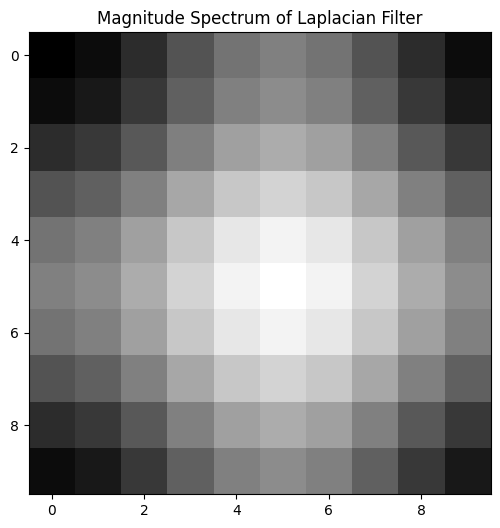

In [12]:
laplacian_filter = laplacian(10)
laplacian_dft = dft(laplacian_filter)
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(laplacian_dft), cmap='gray')
plt.title('Magnitude Spectrum of Laplacian Filter')
plt.show()

we can clearly see at dc(0,0) we have almost 0 attenuation then as we go higher in freq we can see amplification hence this is high pass filter note that laplacian parameter only this we can do size which doesnt make much difference.

## Q3

### 1a)

In [16]:
def noising_image(I, mean=0, sigma=5):
    noise = np.random.normal(mean,sigma, size=I.shape)
    return  I + noise

noised_img = noising_image(np.array(img))

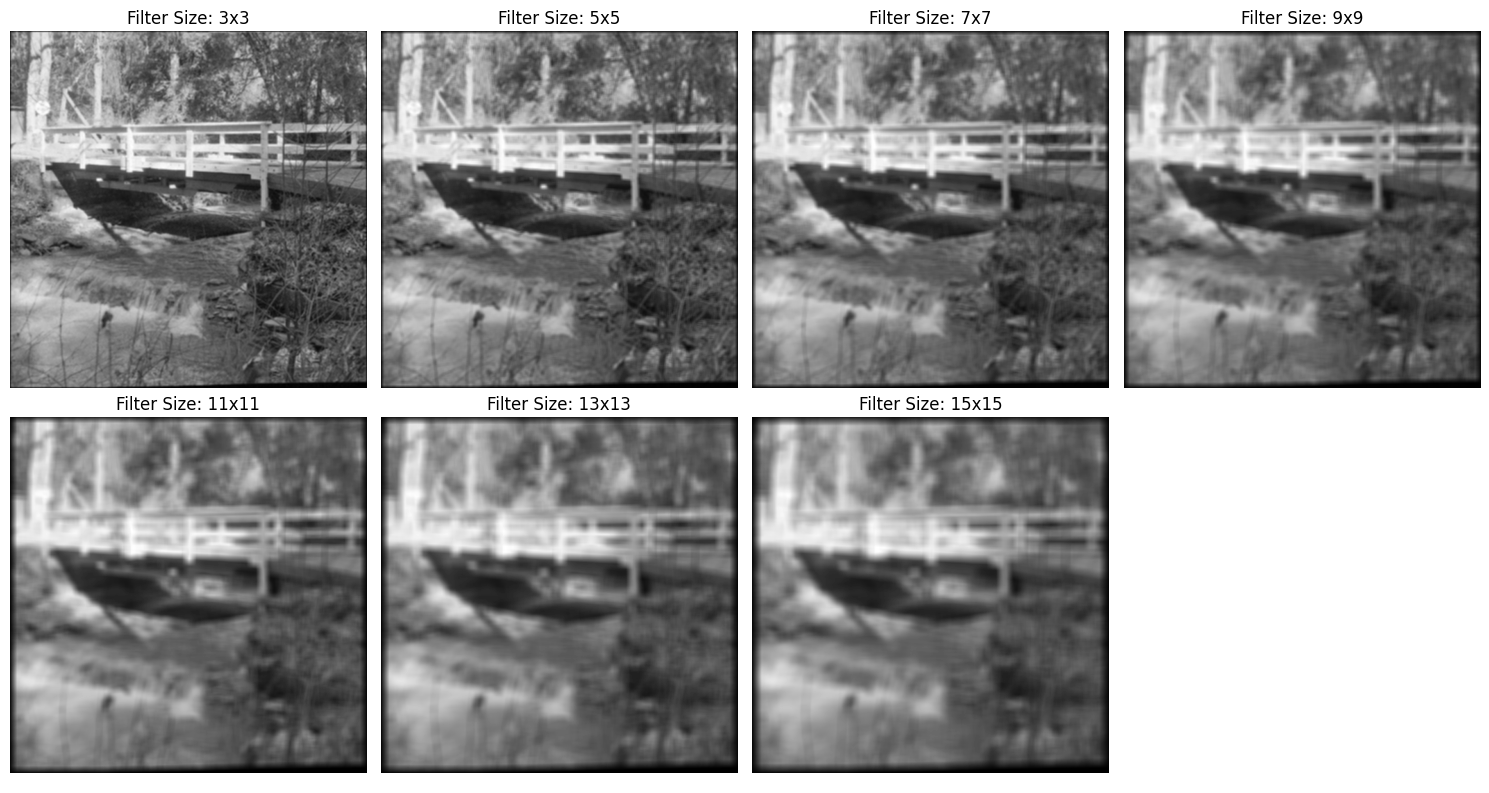

In [ ]:
sizes = list(range(3, 16, 2))
num_columns = 4
num_rows = (len(sizes) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 4*num_rows))

for i, size in enumerate(sizes):
    row_index = i // num_columns
    col_index = i % num_columns
    filt = avg_filter(size)
    result = linear_convolution_freq(noised_img, filt)
    axes[row_index, col_index].imshow(result, cmap='gray')
    axes[row_index, col_index].set_title(f'Filter Size: {size}x{size}')
    axes[row_index, col_index].axis('off')
    
for i in range(len(sizes), num_rows * num_columns):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

we can see as filter size increases the images is denoised better but the disadvanatage is along with noise less significant edges will also get smoothened so we can see 3 can be optimal for variance of 25 anything above that causes less significant edges to smooth as well.

### 1b)

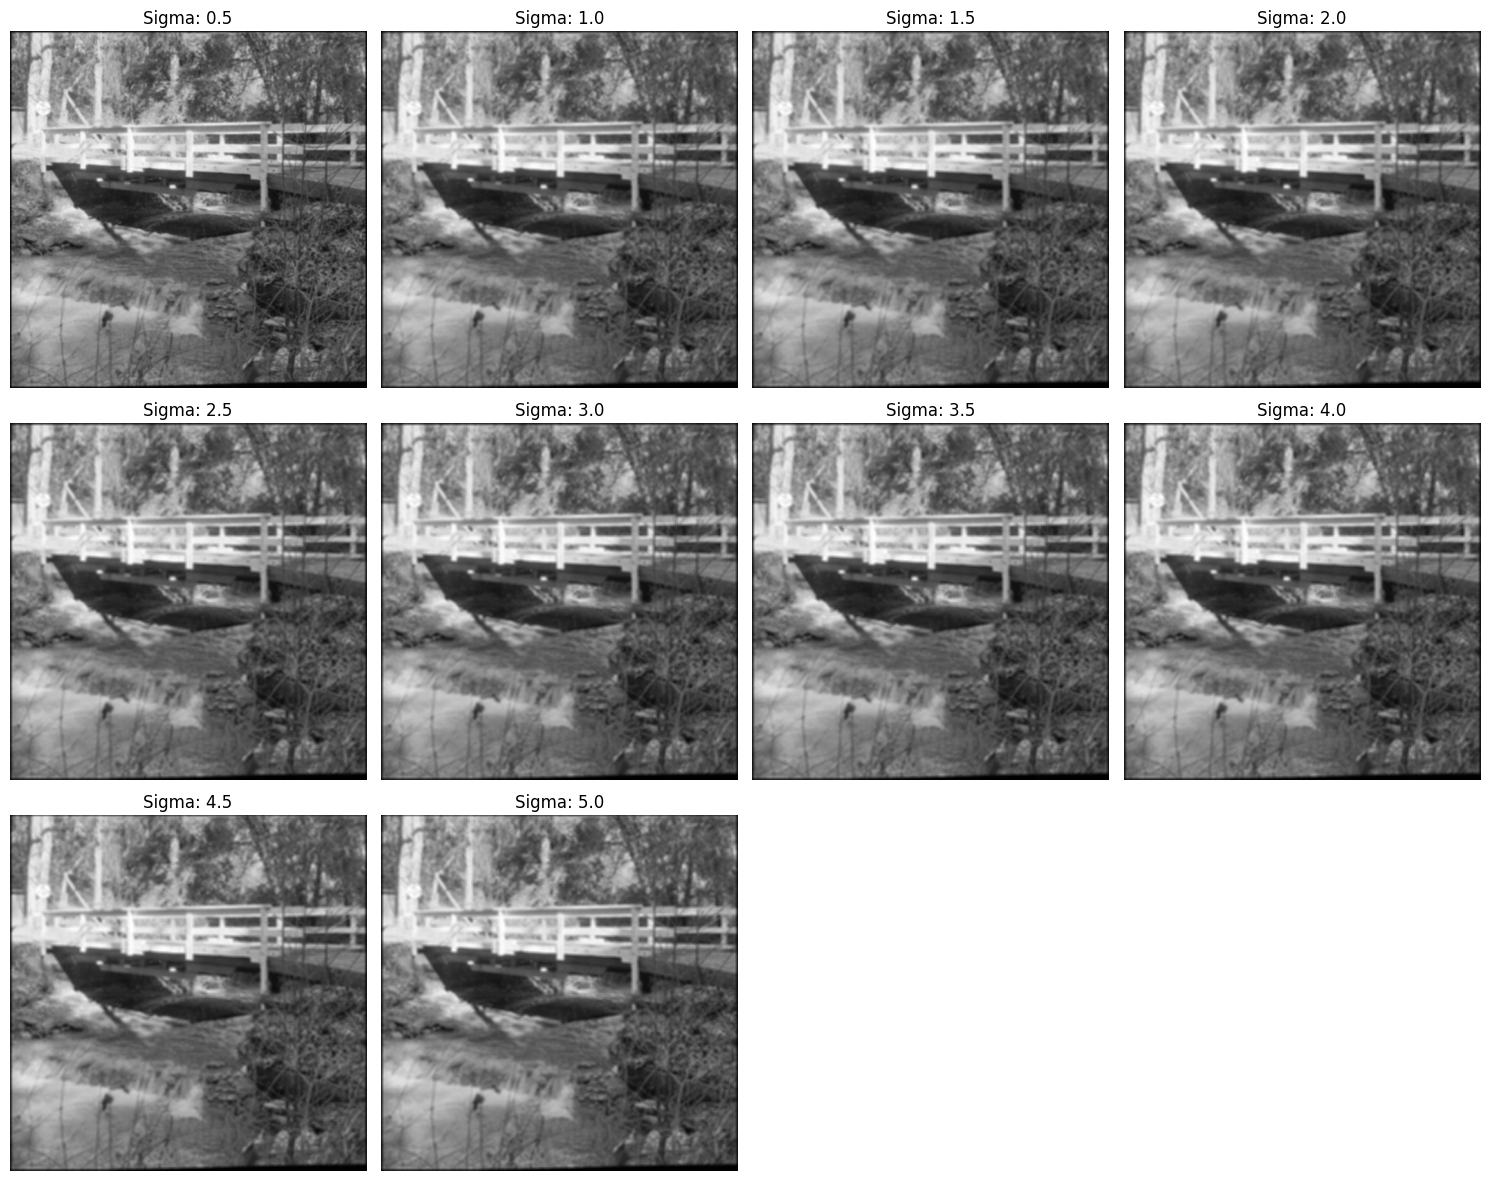

In [ ]:
sigma_values = np.arange(0.5, 5.5, 0.5)
num_columns = 4
num_rows = (len(sigma_values) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15,4*num_rows))

for i, sigma in enumerate(sigma_values):
    row_index = i // num_columns
    col_index = i % num_columns
    filt = gaussian_filter(5, sigma)
    result = linear_convolution_freq(noised_img, filt)
    axes[row_index, col_index].imshow(result, cmap='gray')
    axes[row_index, col_index].set_title(f'Sigma: {sigma}')
    axes[row_index, col_index].axis('off')

for i in range(len(sigma_values), num_rows * num_columns):
    axes.flatten()[i].axis('off')
    
plt.tight_layout()
plt.show()

we can see as sigma increases we can see more denoising but also smoothening of less signifant edges like backgroung leaves.so the optimal choise seems like sigma = 0.5 at varinace of 25

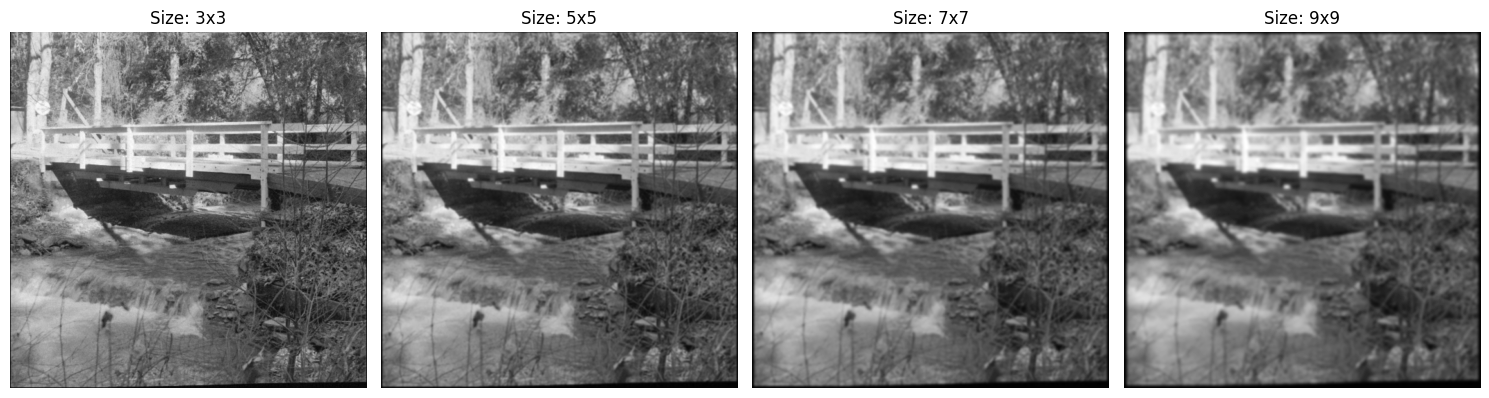

In [24]:
sizes = [3, 5, 7, 9]
num_columns = 4
num_rows = (len(sizes) - 1) // num_columns + 1
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 4*num_rows))

for i, size in enumerate(sizes):
    row_index = i // num_columns
    col_index = i % num_columns
    filt = gaussian_filter(size, 0.5)  
    result = linear_convolution_freq(noised_img, filt)
    axes[i].imshow(result, cmap='gray')  
    axes[i].set_title(f'Size: {size}x{size}')
    axes[i].axis('off')

for i in range(len(sizes), num_rows * num_columns):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

we can see from the above if we fix the sigma and increase the kernal size the effect is similar to increasing window size of average filter.more denoising but also smoothing of less significant edges so balance is required the optimal choice seems like 3 given varince is 25

### 2

In [5]:
color_image = Image.open("misc/4.2.03.tiff")
baboon = color_image.convert("L")

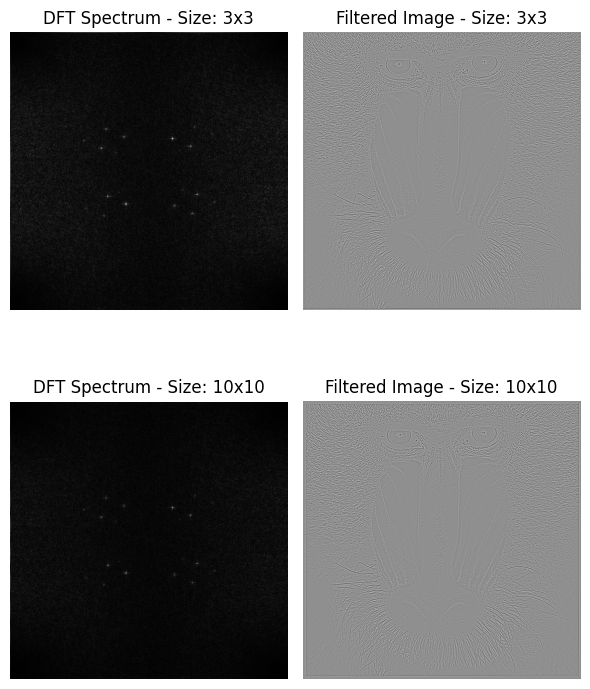

In [13]:
#high pass filter
sizes = [3,10]
fig, axes = plt.subplots(len(sizes), 2, figsize=(6,4*len(sizes)))
for i, size in enumerate(sizes):
    filt = laplacian(size)
    result = linear_convolution_freq(np.array(baboon), filt)
    result_dft = np.abs(dft(result))

    # Plot DFT spectrum
    axes[i, 0].imshow(result_dft, cmap='gray')
    axes[i, 0].set_title(f'DFT Spectrum - Size: {size}x{size}')
    axes[i, 0].axis('off')
    # Plot resulting image
    axes[i, 1].imshow(result, cmap='gray')
    axes[i, 1].set_title(f'Filtered Image - Size: {size}x{size}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

we can see changing lapalcian filter size has not much effect on the filtered image

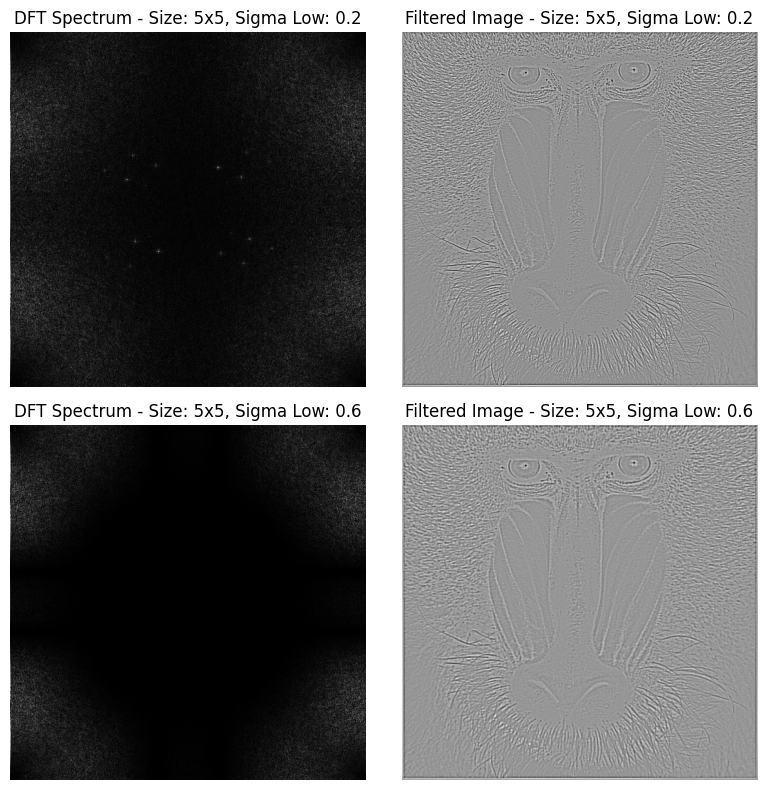

In [12]:
#band pass filter
size = 5
sigma_lows = [0.2, 0.6] 
fig, axes = plt.subplots(len(sigma_lows), 2, figsize=(8,4*len(sigma_lows)))

for i, sigma_low in enumerate(sigma_lows):
    filt = band_pass(size, sigma_low,0.8)  
    result = linear_convolution_freq(np.array(baboon), filt)
    result_dft = np.abs(dft(result))
    # Plot DFT spectrum
    axes[i, 0].imshow(result_dft, cmap='gray')
    axes[i, 0].set_title(f'DFT Spectrum - Size: {size}x{size}, Sigma Low: {sigma_low}')
    axes[i, 0].axis('off')
    # Plot resulting image
    axes[i, 1].imshow(result, cmap='gray')
    axes[i, 1].set_title(f'Filtered Image - Size: {size}x{size}, Sigma Low: {sigma_low}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In a bandpass filter, when the sigma of the high-pass filter is fixed and the sigma of the low-pass filter is increased, the edges within the filtered signal has slighly less details. This is because the increased sigma value of the low-pass filter allows less lower-frequency components to pass through.

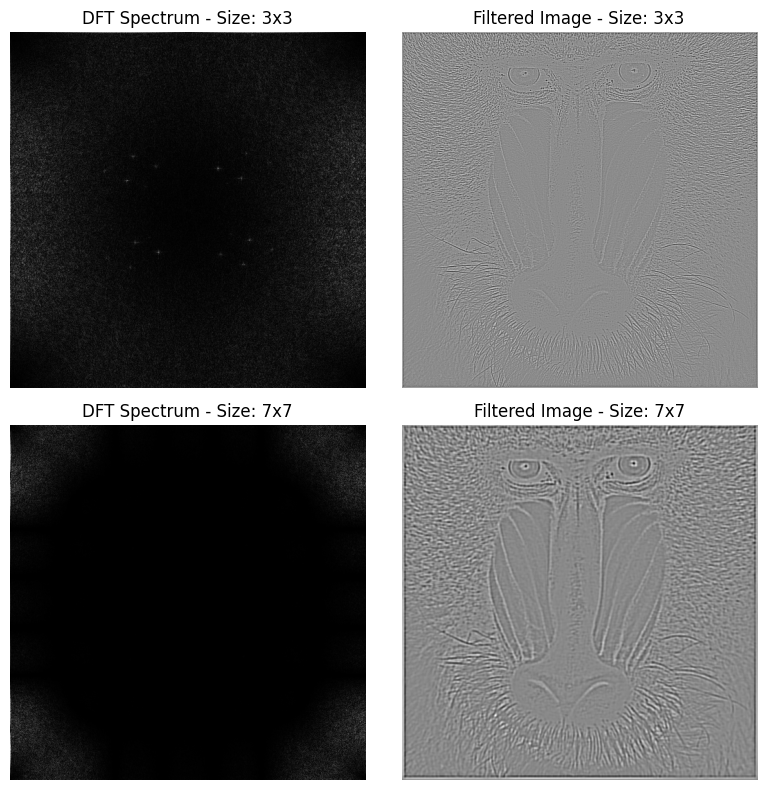

In [10]:
sizes = [3,7]
fig, axes = plt.subplots(len(sizes), 2, figsize=(8,4*len(sizes)))

for i, size in enumerate(sizes):
    filt = band_pass(size, 0.5, 1.5)
    result = linear_convolution_freq(np.array(baboon), filt)  
    result_dft = np.abs(dft(result)) 

    # Plot DFT spectrum
    axes[i, 0].imshow(result_dft, cmap='gray')
    axes[i, 0].set_title(f'DFT Spectrum - Size: {size}x{size}')
    axes[i, 0].axis('off')
    
    # Plot resulting image
    axes[i, 1].imshow(result, cmap='gray')
    axes[i, 1].set_title(f'Filtered Image - Size: {size}x{size}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

we can see if we increase the size of kernal we can see edges more clearly but the details are less compared to small size kernals.